In [35]:
import cv2
import numpy as np
from tqdm import tqdm
import bisect
from loguru import logger
import matplotlib.pyplot as plt
from converter import UTMtoLL, LLtoUTM
import os

In [ ]:
def extract_lat_lon_from_file(file_path):
    lat, lon = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('latitude:'):
                lat = float(line.strip().split(':')[1])
            elif line.strip().startswith('longitude:'):
                lon = float(line.strip().split(':')[1])
    return [lat, lon] if lat is not None and lon is not None else None

def read_all_casualty_coords(directory):
    coords = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            lat_lon = extract_lat_lon_from_file(file_path)
            if lat_lon:
                coords.append(lat_lon)
    return coords

# Example usage:
directory_path = '/mnt/UNENCRYPTED/ruichend/seq/dry_run_1/GT'
casualty_gps = np.array(read_all_casualty_coords(directory_path))
casualty_coords = np.array([LLtoUTM(23, lat, lon) for lat, lon in casualty_gps])[:, 1:3].astype(np.float32)  # Extracting easting and northing

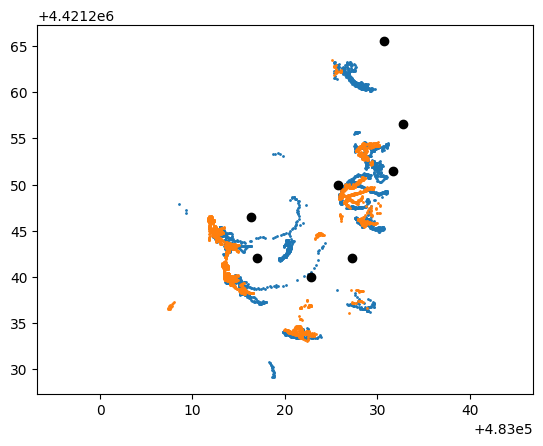

In [ ]:
target = np.load('logs/with_ts3.npy')
plt.axis('equal')
target1 = target[:len(target)//2, :2]  # Use only the first two columns for plotting
plt.scatter(target1[:, 1], target1[:, 0],  s=1)
target2 = target[len(target)//2:, :2]  # Use only the first two columns for plotting
plt.scatter(target2[:, 1], target2[:, 0],  s=1)
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], label='Ground Truth', color='black')

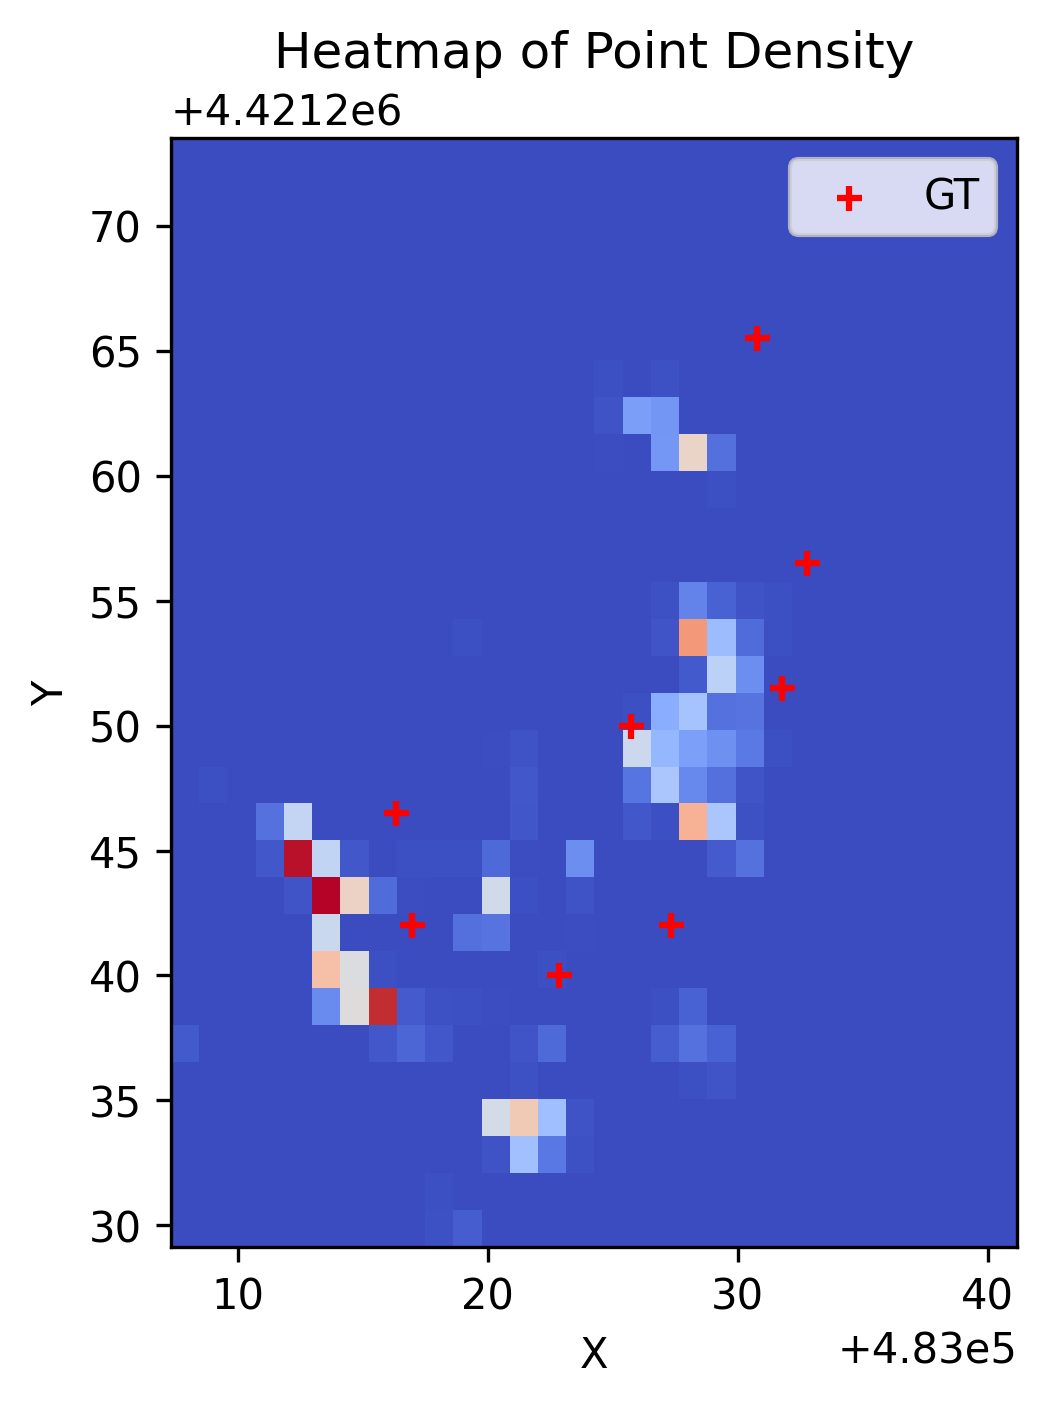

In [76]:


xmin = np.min(target[:, 1])
xmax = np.max(target[:, 1])
ymin = np.min(target[:, 0])
ymax = np.max(target[:, 0])
range = [[xmin, xmax+10], [ymin, ymax+10]]
heatmap, xedges, yedges = np.histogram2d(target[:, 1], target[:, 0], bins=30, range = range)
extent = [xmin, xmax+10, ymin, ymax+10]

plt.figure(dpi=300)
# plt.axis('equal')
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
# plt.imshow(np.ma.masked_where(heatmap.T == 0, heatmap.T), cmap=cmap)

plt.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', cmap="coolwarm")
# plt.colorbar(label='Density')
plt.title('Heatmap of Point Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], marker='+', label='GT', color='r')
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ---- Input ----
coordinates = target  # shape: (N, 2), e.g. (northing, easting)
output_dir = 'heatmap_frames'
output_video = 'heatmap_progression.mp4'
fps = 30
bins = 50  # resolution of heatmap

# ---- Setup ----
os.makedirs(output_dir, exist_ok=True)

# Determine range
x_min, x_max = np.min(coordinates[:, 0]), np.max(coordinates[:, 0])
y_min, y_max = np.min(coordinates[:, 1]), np.max(coordinates[:, 1])
hist_range = [[x_min, x_max], [y_min, y_max]]

# ---- Generate heatmap frames ----
for i in range(1, len(coordinates) + 1):
    data = coordinates[:i]  # Use first i coordinates
    hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=bins, range=hist_range)

    plt.figure(figsize=(6, 6))
    plt.imshow(
        hist.T,
        origin='lower',
        extent=[x_min, x_max, y_min, y_max],
        # cmap='hot',
        interpolation='nearest',
        aspect='auto'
    )
    plt.colorbar(label='Frequency')
    plt.title(f'Frame {i}: Heatmap')
    plt.xlabel('East')
    plt.ylabel('North')
    plt.savefig(f"{output_dir}/{i:04d}.png")
    plt.close()

# ---- Write video ----
images = sorted([img for img in os.listdir(output_dir) if img.endswith(".png")])
frame_path = os.path.join(output_dir, images[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

for image in images:
    frame = cv2.imread(os.path.join(output_dir, image))
    video_writer.write(frame)

video_writer.release()
print(f"Video saved to {output_video}")

Video saved to heatmap_progression.mp4


In [20]:
hist.shape

(50, 50)

In [27]:
ros_record = np.load('logs/dr1_dect_pose2.npy', allow_pickle=True).tolist()

In [30]:
all_trajectory = []
all_detections = []
for data in ros_record:
    all_trajectory.append(data['translation'][:2])  # northing, easting
    for det in data['detections']:
        det_coords = np.array([(det[0] + det[2]) // 2, (det[1] + det[3]) // 2])  # center of the box
        all_detections.append(det_coords)
all_trajectory = np.array(all_trajectory, dtype=np.float32)
all_detections = np.array(all_detections, dtype=np.float32)

In [34]:
all_trajectory.shape

(3585, 2)

In [32]:
all_detections.shape

(6107, 2)

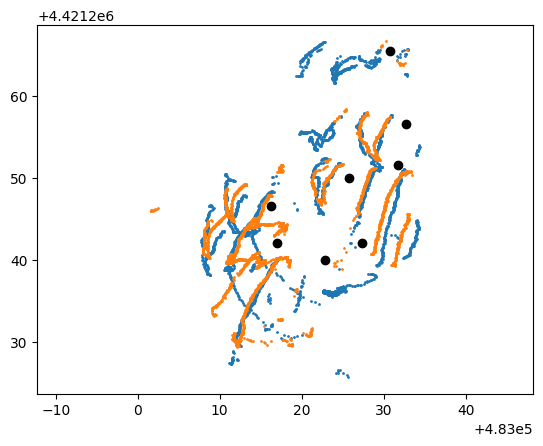

In [ ]:
target = np.load('logs/with_ts.npy')
plt.axis('equal')
target1 = target[:len(target)//2, :2]  # Use only the first two columns for plotting
plt.scatter(target1[:, 1], target1[:, 0],  s=1)
target2 = target[len(target)//2:, :2]  # Use only the first two columns for plotting
plt.scatter(target2[:, 1], target2[:, 0],  s=1)
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], label='Ground Truth', color='black')

In [21]:
a = []
b = 1
c = []


In [22]:
a.append(c)

In [23]:
a

[[]]